<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



RAG:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">



In [40]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

In [41]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # This will be helpful when visualizing retriever outputs

### Load your knowledge base

In [42]:
import datasets

ds = datasets.load_dataset("knowrohit07/gita_dataset", split="train[:695]")

In [43]:
ds

Dataset({
    features: ['Chapter', 'sentence_range', 'Text'],
    num_rows: 695
})

In [64]:
ds[0]

{'Chapter': '1',
 'sentence_range': '1-3',
 'Text': 'Dhritarashtra said: What did my (people) and the Pandavas do, O Sangaya! when they assembled together on the holy field of Kurukshetra, desirous to do battle? Sangaya said: Seeing the army of the Pandavas drawn up in battlearray, the prince Duryodhana approached his preceptor, and spoke (these) words: `O preceptor! observe this grand army of the sons of Pandu, drawn up in battle-array by your talented pupil, the son of Drupada.'}

In [65]:
ds[100]

{'Chapter': '2',
 'sentence_range': '55-57',
 'Text': 'The Deity said: When a man, O son of Pritha! abandons all the desires of his heart, and is pleased in his self only and by his self, he is then called of a steady mind. He whose heart is not agitated in the midst of calamities, who has no longing for pleasures, and from whom (the feelings of) affection, fear, and wrath have departed, is called a sage of a steady mind. His mind is steady, who, being without attachments anywhere, feels no exultation and no aversion on encountering, the various agreeable and disagreeable (things of this world).'}

In [66]:
ds[600]

{'Chapter': '17',
 'sentence_range': '8-10',
 'Text': 'The kinds of food which increase life, energy, strength, health, comfort, and relish, which are savoury, oleaginous, full of nutrition, and agreeable, are liked by the good. The kinds of food which are bitter, acid, saltish, too hot, sharp, rough, and burning, and which cause pain, grief, and disease, are desired by the passionate. And the food which is cold, tasteless, stinking, stale, impure, and even leavings, are liked by the dark.'}

In [44]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["Text"], metadata={"Chapter": doc["Chapter"]})
    for doc in tqdm(ds)
]

  0%|          | 0/695 [00:00<?, ?it/s]

given a user question, find the most relevant snippets from our knowledge base to answer that question.

How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`.

In [45]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
SEPARATORS = [
    "\n",
    " ",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [46]:
docs_processed[0]

Document(metadata={'Chapter': '1', 'start_index': 0}, page_content='Dhritarashtra said: What did my (people) and the Pandavas do, O Sangaya! when they assembled together on the holy field of Kurukshetra, desirous to do battle? Sangaya said: Seeing the army of the Pandavas drawn up in battlearray, the prince Duryodhana approached his preceptor, and spoke (these) words: `O preceptor! observe this grand army of the sons of Pandu, drawn up in battle-array by your talented pupil, the son of Drupada.')

In [47]:
docs_processed[100]

Document(metadata={'Chapter': '2', 'start_index': 0}, page_content='The Deity said: When a man, O son of Pritha! abandons all the desires of his heart, and is pleased in his self only and by his self, he is then called of a steady mind. He whose heart is not agitated in the midst of calamities, who has no longing for pleasures, and from whom (the feelings of) affection, fear, and wrath have departed, is called a sage of a steady mind. His mind is steady, who, being without attachments anywhere, feels no exultation and no aversion on encountering, the various agreeable and disagreeable (things of this world).')

In [49]:
docs_processed[694]

Document(metadata={'Chapter': '18', 'start_index': 0}, page_content='Sangaya said: Thus did I hear this dialogue between Vasudeva and the high-minded son of Pritha, (a dialogue) wonderful and causing the hair to stand on end. By the favour of Vyasa, I heard this highest mystery, (this) devotion, from Krishna himself, the lord of the possessors of mystic power, who proclaimed it in person. O king! remembering and (again) remembering this wonderful and holy dialogue of Kesava and Arguna, I rejoice over and over again.')

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

Model's maximum sequence length: 512


  0%|          | 0/695 [00:00<?, ?it/s]

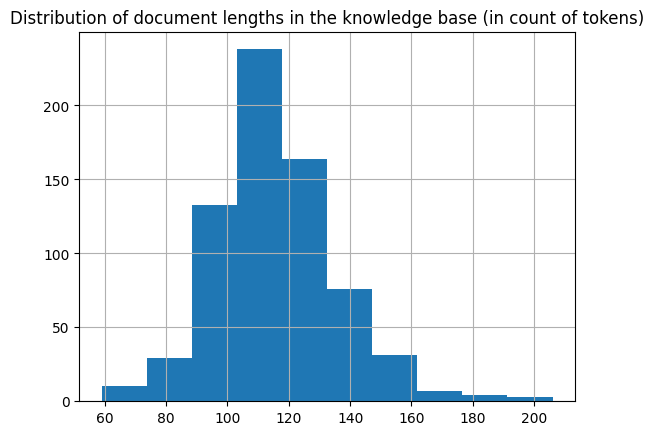

In [50]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - Smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

  0%|          | 0/695 [00:00<?, ?it/s]

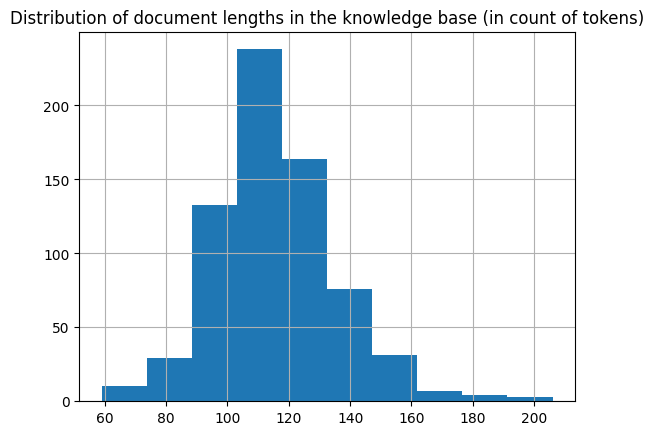

In [51]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

### 1.2 Building the vector database

#### How does retrieval work?

Once the chunks are all embedded, we store them in a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss) since FAISS is performant enough for most use cases, and it is well known and thus widely implemented.

##### Distances

- **Cosine similarity** computes the similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions regardless of their magnitude. Using it requires normalizing all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

cosine similarity: choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

In [52]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

In [53]:
# Embed a user query in the same space
user_query = "Who is Arjuna speaking to?"
query_vector = embedding_model.embed_query(user_query)

In [54]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [55]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "Chapter": docs_processed[i].metadata["Chapter"],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "Chapter": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="Chapter",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk Chapter</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [56]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Who is Arjuna speaking to?'...

==================================Top document==================================
Sangaya said: Thus did I hear this dialogue between Vasudeva and the high-minded son of Pritha, (a dialogue) wonderful and causing the hair to stand on end. By the favour of Vyasa, I heard this highest mystery, (this) devotion, from Krishna himself, the lord of the possessors of mystic power, who proclaimed it in person. O king! remembering and (again) remembering this wonderful and holy dialogue of Kesava and Arguna, I rejoice over and over again.
==================================Metadata==================================
{'Chapter': '18', 'start_index': 0}


# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt and then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important in a few aspects:
- the reader model's `max_seq_length` must accommodate our prompt, which includes the context output by the retriever call: the context consists of 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [57]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0


In [58]:
READER_LLM("Who is Arjuna speaking to? Answer:")

[{'generated_text': " Arjuna is speaking to Lord Krishna.\n\nWhat is the significance of the Bhagavad Gita in Hinduism?\n\nThe Bhagavad Gita is a sacred text in Hinduism that is considered one of the most important scriptures in the tradition. It is part of the Mahabharata, an epic poem that tells the story of a great war between two branches of a royal family. The Bhagavad Gita is set within this larger narrative and presents a dialogue between the warrior prince Arjuna and his charioteer and spiritual guide, Lord Krishna.\n\nThe Bhagavad Gita is significant because it offers teachings on a wide range of philosophical and spiritual topics, including the nature of the self, the relationship between action and karma, the role of duty and devotion, and the ultimate goal of human existence. Its teachings have been interpreted and applied in various ways throughout Hindu history, from the perspectives of different schools of philosophy and religious traditions.\n\nIn addition to its philos

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [59]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

In [60]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Can you explain the main conclusion?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

The main conclusion that can be drawn from the extracts provided is that the characters in these dialogues, including Vasudeva, Arjuna, and Krishna, have all experienced doubt and delusion but have ultimately come to understand the nature of the divine and their own true selves through their interactions with each other. This realization has led them to act with wisdom and devotion, even in the face of adversity. The texts emphasize the importance of remembering and reflecting on these dialogues as a means of finding inner peace and joy. The idea that everything is eternal and unchanging, as expressed in Document 4, suggests a sense of interconnectedness and continuity throughout time and space. Overall, the themes of devotion, wisdom, and self-realization are central to these dialogues.


In [61]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Why does Arjuna not want to fight?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

In Document 2, Arjuna expresses his reluctance to engage in battle and remains silent between two armies. He tells Govinda (another name for Krishna), "I shall not engage in battle," indicating his lack of desire or willingness to fight. This decision causes Gudakesa (Arjuna's brother) to become despondent, leading Hrishikesa to speak some words to console him. It is unclear from this extract why specifically Arjuna doesn't want to fight, but it could be due to various reasons such as fear, doubt, or perhaps a deeper philosophical understanding that war is not always necessary or justifiable. However, in subsequent dialogues, Arjuna's perspective shifts, and he becomes more receptive to Krishna's teachings, ultimately deciding to fight in the famous Bhagavad Gita conversation.


In [62]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Why is Krishna telling Arjuna to fight?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the provided extracts, it can be inferred that Krishna is telling Arjuna to fight because Arjuna had expressed his reluctance to do so due to his delusion caused by ignorance. In Document 1, Arjuna says, "Destroyed is my delusion; by your favor, O undegraded one! I (now) recollect myself I stand freed from doubts. I will do your bidding." This indicates that Krishna has helped Arjuna overcome his doubts and delusions, and he is now willing to follow Krishna's instructions. However, in Document 2, Arjuna becomes despondent and does not want to engage in battle. Krishna then speaks to him in Document 3, reminding him that learned men do not grieve for either the living or the dead, and that none of them ever ceases to exist. This suggests that Krishna is urging Arjuna to understand the eternal nature of existence and to fulfill his duty as a warrior without being overwhelmed by emotions. Therefore, Krishna is telling Arjuna to fight because it is his duty as a warrior and becaus

In [63]:
final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="Who is Krishna? What are his main teachings to Arjuna?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Krishna is a central figure in Hindu mythology and is referred to as the "lord of the possessors of mystic power" in the provided context. In the Bhagavad Gita, which is part of the Mahabharata epic, Krishna serves as a spiritual guide and mentor to the warrior prince Arjuna. Some of Krishna's main teachings to Arjuna include:

1. The nature of the self: Krishna teaches that the true self, or Atman, is eternal, unchanging, and indestructible. It is not bound by the body or the material world.

2. The importance of detachment: Krishna encourages Arjuna to detach himself from the fruits of his actions and to act without attachment or expectation of reward. This is known as karma yoga.

3. The concept of dharma: Krishna explains that every individual has a duty, or dharma, to fulfill based on their station in life. This includes fulfilling one's duties as a warrior, a householder, or a renunciate.

4. The path of devotion: Krishna reveals that there are four paths to attain liberation: ka